# Mini Projeto 3

## implementação de uma MLP usando Pytorch

Neste projeto, implementei uma Multi-Layer Perceptron (MLP) usando PyTorch para classificar a base de dados MNIST.

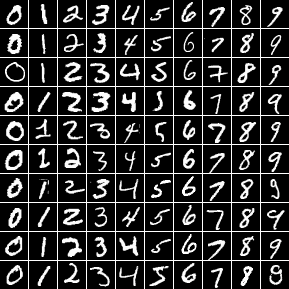

ImpoImportando todas as bibliotecas e a base de dados.

In [1]:
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
from random import random

import matplotlib.pyplot as plt

In [2]:
# Baixar o conjunto de treinamento MNIST, nesse poonto não estou usando nenhuma transformação
batch_size = 128 
base_treinamento = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
base_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [3]:
# Carrega todos os dados
treinamento_img = torch.utils.data.DataLoader(dataset=base_treinamento, batch_size=batch_size, shuffle=True)
teste_img = torch.utils.data.DataLoader(dataset=base_test, batch_size=batch_size, shuffle=False)

Definição do MLP em Pytorch

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Implementação do modelo base de acordo com a solicitação

In [5]:
#Dados da MLP "Direto do classroom"

input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 500  # Número de neurônios na camada oculta
output_size = 10  # Número de saidas possiveis

num_epochs = 5
learning_rate = 0.001

# Definição do modelo
rede = MLP(input_size, hidden_size, output_size)

1. Inicializando o função de otimização (parametros passados no classroom)
2. Iniciando a GPU (para esse caso vou inicia-la apenas se disponivel no PC)

In [6]:
# Inicializando o atimizador

otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate)

PC_Processo = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda ativa GPU
rede.to(PC_Processo) # GPU se disponivel é ativada aqui

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# calculadora de acuracia

In [7]:
def calcular_acuracia(model, data_loader, PC_Processo):
    model.eval()
    corretos = 0
    total = 0
    with torch.no_grad():
        for imagens, rotulos in data_loader:
            imagens = imagens.view(-1, 28*28).to(PC_Processo)
            rotulos = rotulos.to(PC_Processo)
            saidas = model(imagens)
            _, previstos = torch.max(saidas.data, 1)
            total += rotulos.size(0)
            corretos += (previstos == rotulos).sum().item()
    return (corretos / total) * 100  # Multiplicando por 100 para obter a porcentagem

# chegou a hora de testar o modelo na tentativa de receber dados
## para assim ver os resultados e desse modo aplicar possiveis mudanças

In [8]:
def treinar_e_avaliar(model, treinamento_loader, teste_loader, otimizador, num_epochs, PC_Processo): # função que calcula e treina minha IA (serve para facilitar minha vida em seguida)
    acuracias = []
    criterio = nn.CrossEntropyLoss()
    # Avaliação inicial
    acuracia_inicial = calcular_acuracia(model, teste_loader, PC_Processo)
    acuracias.append(acuracia_inicial)
    print(f"Acurácia inicial: {acuracia_inicial:.4f}")

    # Loop de treinamento
    for epoch in range(num_epochs):
        for i, (imagens, rotulos) in enumerate(treinamento_loader):
            imagens = imagens.view(-1, 28*28).to(PC_Processo)
            rotulos = rotulos.to(PC_Processo)

            # Forward pass
            saidas = model(imagens)
            perda = criterio(saidas, rotulos)

            # Backward pass e otimização
            otimizador.zero_grad()
            perda.backward()
            otimizador.step()

        # Avaliação no conjunto de teste (ou validação) ao final de cada época
        acuracia_epoca = calcular_acuracia(model, teste_loader, PC_Processo)
        acuracias.append(acuracia_epoca)

        # Imprimindo informações
        print(f'Época [{epoch+1}/{num_epochs}], Acurácia de Teste: {acuracia_epoca:.4f}')

    return acuracias

In [9]:
# Exemplo de uso
acuracias_treinamento = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)
valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)

Acurácia inicial: 8.0600
Época [1/5], Acurácia de Teste: 49.5200
Época [2/5], Acurácia de Teste: 61.7400
Época [3/5], Acurácia de Teste: 69.2000
Época [4/5], Acurácia de Teste: 73.7200
Época [5/5], Acurácia de Teste: 76.8300


Plot dos resultados

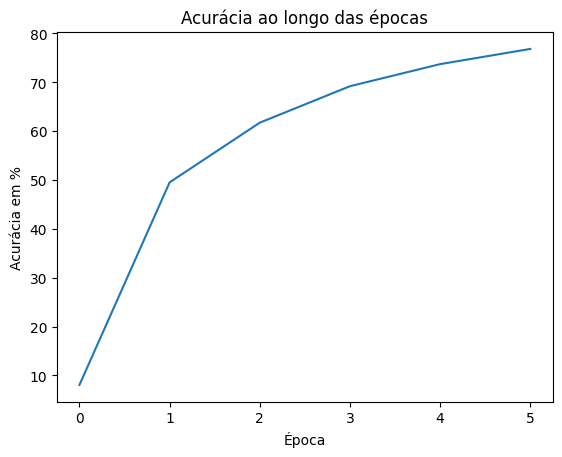

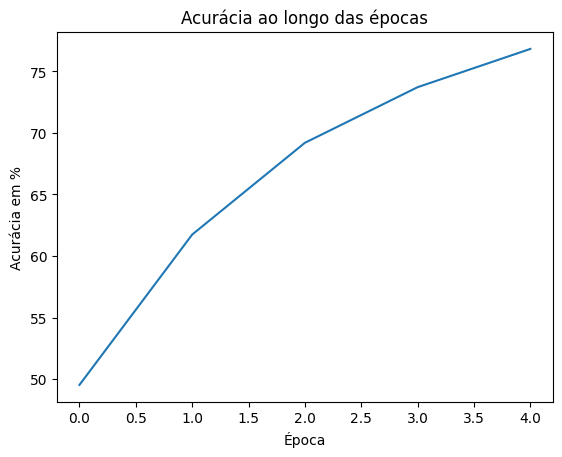

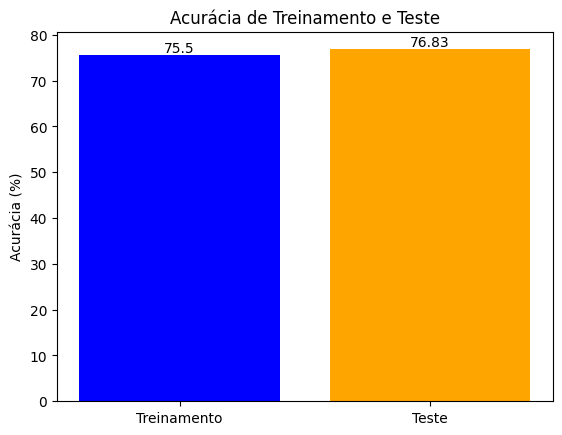

[8.06, 49.519999999999996, 61.739999999999995, 69.19999999999999, 73.72, 76.83]
[75.49833333333333, 76.83]


In [10]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento)
print([valor_treino, valor_teste])


Dado o resultado anterior percebi que que logo após a primeira interação o mesmo esta demorando muito para chegar ao melhor resultado possivel, logo resolvi almenatr o LR na tentativa de acelerar o processo alem de reduzir a complexidade da camada reduzindo o numero de neuronios

In [11]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 258  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 10
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 6.4800
Época [1/10], Acurácia de Teste: 73.7200
Época [2/10], Acurácia de Teste: 82.4700
Época [3/10], Acurácia de Teste: 84.9000
Época [4/10], Acurácia de Teste: 86.6700
Época [5/10], Acurácia de Teste: 87.6400
Época [6/10], Acurácia de Teste: 88.4100
Época [7/10], Acurácia de Teste: 88.8300
Época [8/10], Acurácia de Teste: 89.3100
Época [9/10], Acurácia de Teste: 89.7100
Época [10/10], Acurácia de Teste: 89.9100


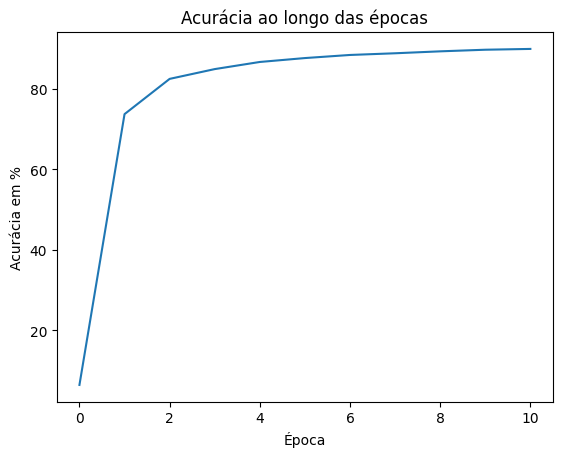

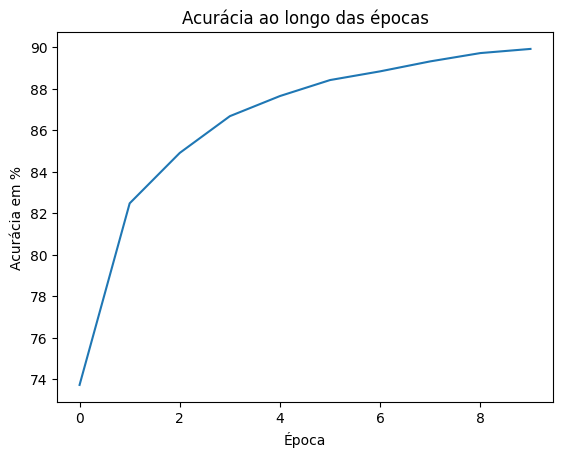

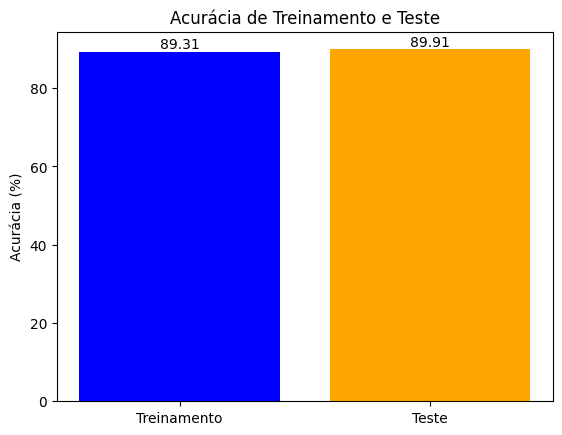

In [12]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


Foi possivel obseravar uma grande melhora em comparação ao anterior, tambem vale a pena observar que não é um problema nem de underfitting ou overfitting ja que os dados quando comparados treino e teste são quanse identicos.

Em seguida reamais uma redução na camada oculta, para reduzir a complexidade.

In [13]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 120  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 15
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 12.1600
Época [1/15], Acurácia de Teste: 72.9200
Época [2/15], Acurácia de Teste: 79.7100
Época [3/15], Acurácia de Teste: 83.7500
Época [4/15], Acurácia de Teste: 85.8800
Época [5/15], Acurácia de Teste: 87.3600
Época [6/15], Acurácia de Teste: 88.2700
Época [7/15], Acurácia de Teste: 88.9200
Época [8/15], Acurácia de Teste: 89.4400
Época [9/15], Acurácia de Teste: 89.7700
Época [10/15], Acurácia de Teste: 89.9000
Época [11/15], Acurácia de Teste: 90.1400
Época [12/15], Acurácia de Teste: 90.3800
Época [13/15], Acurácia de Teste: 90.4200
Época [14/15], Acurácia de Teste: 90.6400
Época [15/15], Acurácia de Teste: 90.8600


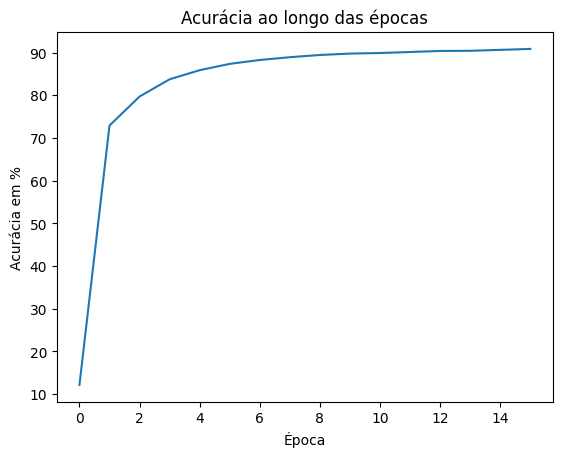

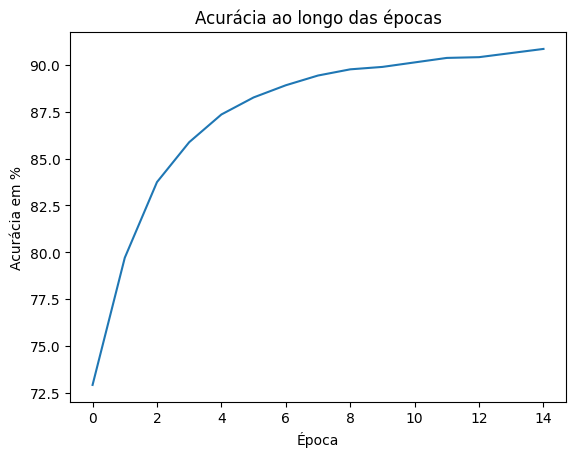

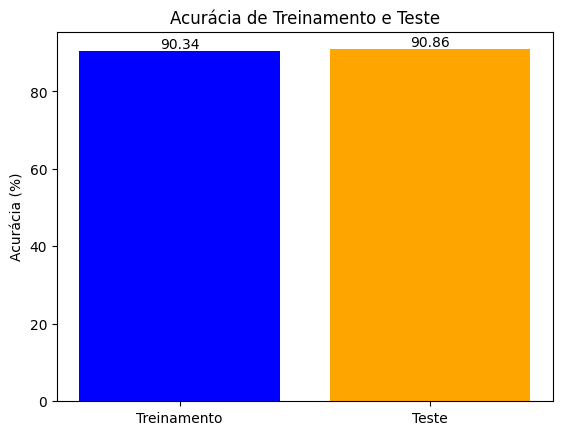

[12.16, 72.92, 79.71000000000001, 83.75, 85.88, 87.36, 88.27000000000001, 88.92, 89.44, 89.77000000000001, 89.9, 90.14, 90.38000000000001, 90.42, 90.64, 90.86]
[90.33833333333334, 90.86]


In [14]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])


É perceptível que não houve muita diferença, logo irei realizar mais um teste, manter o LR já que parece estável além de aumentar o número de episódios já que o crescimento ainda se mostra bem evidente e contínuo epor fim almentar a camada interna ja que os resultados parecem levemente menores.

In [15]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 150  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 25
batch_size = 128 
learning_rate = 0.01

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 11.8100
Época [1/25], Acurácia de Teste: 81.0900
Época [2/25], Acurácia de Teste: 86.5000
Época [3/25], Acurácia de Teste: 88.5200
Época [4/25], Acurácia de Teste: 89.2800
Época [5/25], Acurácia de Teste: 89.7900
Época [6/25], Acurácia de Teste: 90.1100
Época [7/25], Acurácia de Teste: 90.6200
Época [8/25], Acurácia de Teste: 90.9000
Época [9/25], Acurácia de Teste: 91.0800
Época [10/25], Acurácia de Teste: 91.4500
Época [11/25], Acurácia de Teste: 91.6000
Época [12/25], Acurácia de Teste: 91.8900
Época [13/25], Acurácia de Teste: 92.1000
Época [14/25], Acurácia de Teste: 92.1600
Época [15/25], Acurácia de Teste: 92.3800
Época [16/25], Acurácia de Teste: 92.5100
Época [17/25], Acurácia de Teste: 92.6300
Época [18/25], Acurácia de Teste: 92.7700
Época [19/25], Acurácia de Teste: 92.9500
Época [20/25], Acurácia de Teste: 92.9800
Época [21/25], Acurácia de Teste: 93.0600
Época [22/25], Acurácia de Teste: 93.2200
Época [23/25], Acurácia de Teste: 93.4000
Época [24/25], Ac

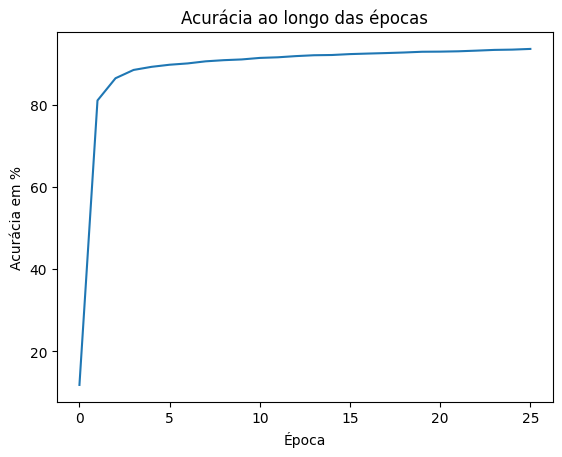

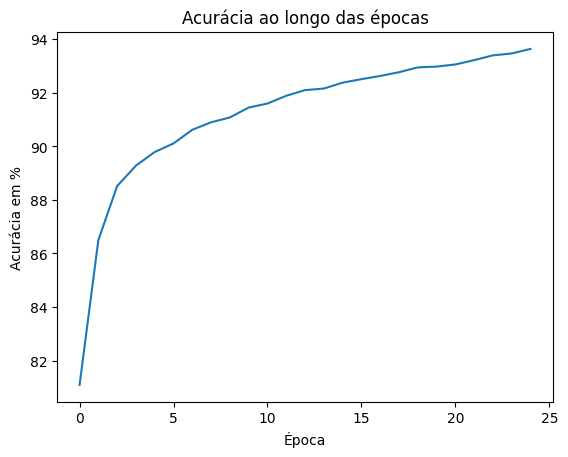

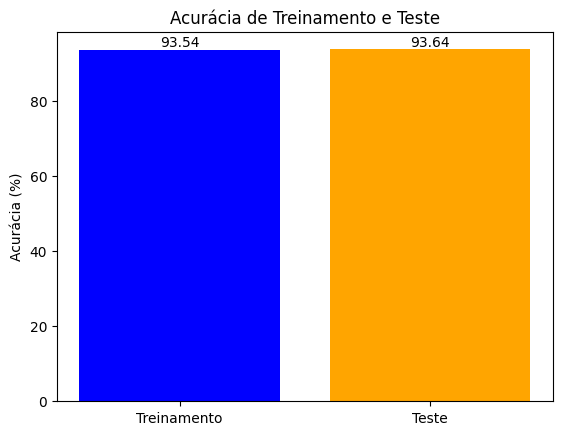

[11.81, 81.08999999999999, 86.5, 88.52, 89.28, 89.79, 90.11, 90.62, 90.9, 91.08000000000001, 91.45, 91.60000000000001, 91.89, 92.10000000000001, 92.16, 92.38, 92.51, 92.63, 92.77, 92.95, 92.97999999999999, 93.06, 93.22, 93.4, 93.47, 93.64]
[93.53666666666666, 93.64]


In [16]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])


# Nota final

Fica notavel que apesar de o modelo melhorar a cada epsodio o mesmo esta melhorando de forma bem linear

[94.53666666666666, 94.35] # valores de acuracia de treino e teste respectivamente.

# Vale a pena salientar que como estamos lidando com a escrita humana não achei legal aplicar transformações as imagens
coisa que testei e se provou verdade demorando 18 epsodios para chegar a 90% de acuracia

abaixo mais um pq não aguentei, nesse caso como ainda havia espaço para melhora contínua no anterior, resolvi aumentar  mais uma vez o LR


In [17]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 150  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 30
batch_size = 128 
learning_rate = 0.05

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 13.5600
Época [1/30], Acurácia de Teste: 90.0200
Época [2/30], Acurácia de Teste: 91.4700
Época [3/30], Acurácia de Teste: 92.3500
Época [4/30], Acurácia de Teste: 92.8700
Época [5/30], Acurácia de Teste: 93.6400
Época [6/30], Acurácia de Teste: 93.8800
Época [7/30], Acurácia de Teste: 94.3800
Época [8/30], Acurácia de Teste: 94.7500
Época [9/30], Acurácia de Teste: 94.9700
Época [10/30], Acurácia de Teste: 95.2300
Época [11/30], Acurácia de Teste: 95.4900
Época [12/30], Acurácia de Teste: 95.7900
Época [13/30], Acurácia de Teste: 95.8700
Época [14/30], Acurácia de Teste: 96.0800
Época [15/30], Acurácia de Teste: 96.3700
Época [16/30], Acurácia de Teste: 96.4000
Época [17/30], Acurácia de Teste: 96.4100
Época [18/30], Acurácia de Teste: 96.5900
Época [19/30], Acurácia de Teste: 96.6300
Época [20/30], Acurácia de Teste: 96.7700
Época [21/30], Acurácia de Teste: 96.7700
Época [22/30], Acurácia de Teste: 96.8800
Época [23/30], Acurácia de Teste: 96.8900
Época [24/30], Ac

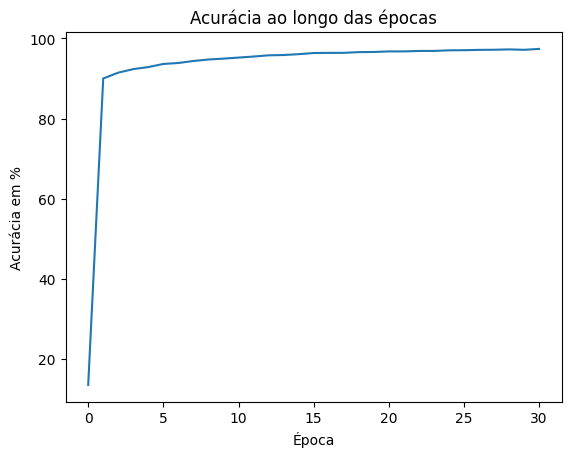

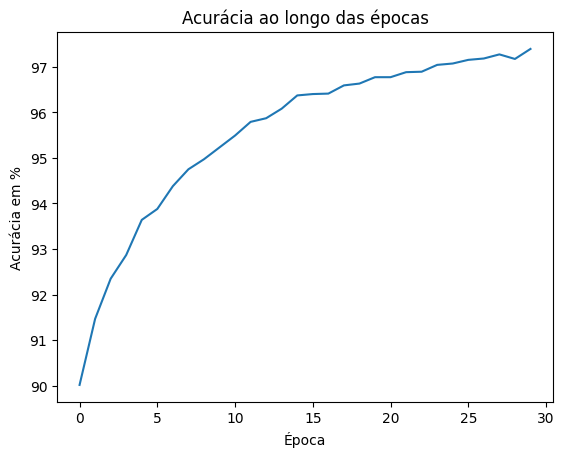

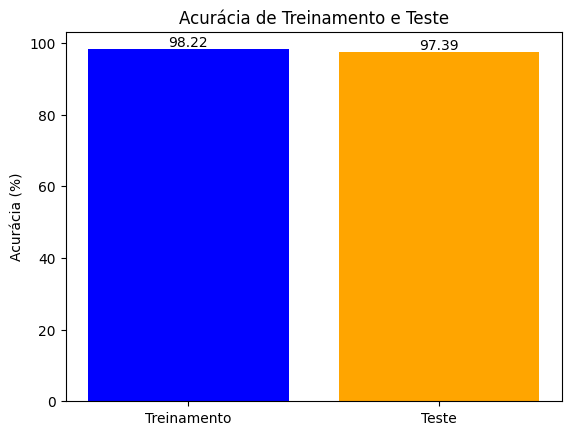

[13.56, 90.02, 91.47, 92.35, 92.86999999999999, 93.64, 93.88, 94.38, 94.75, 94.97, 95.23, 95.49, 95.78999999999999, 95.87, 96.08, 96.37, 96.39999999999999, 96.41, 96.59, 96.63000000000001, 96.77, 96.77, 96.88, 96.89, 97.04, 97.07000000000001, 97.15, 97.18, 97.27, 97.17, 97.39]
[98.21666666666667, 97.39]


In [18]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])


In [19]:
def salvar_modelo(modelo, nome_arquivo):
    torch.save(modelo.state_dict(), nome_arquivo)
    print(f"Modelo salvo como '{nome_arquivo}'.")

# Exemplo de uso para salvar o modelo 'rede' como 'modelo_salvo.pth'
nome_arquivo_salvar = 'modelo_salvo.pth'
salvar_modelo(rede, nome_arquivo_salvar)


Modelo salvo como 'modelo_salvo.pth'.


In [20]:
def carregar_modelo(caminho_arquivo):
    modelo = MLP(input_size, hidden_size, output_size)  # Certifique-se de ter a mesma arquitetura do modelo salvo
    modelo.load_state_dict(torch.load(caminho_arquivo))
    modelo.eval()  # Define o modelo para modo de avaliação
    print(f"Modelo carregado de '{caminho_arquivo}'.")
    return modelo

# Exemplo de uso para carregar o modelo 'modelo_salvo.pth'
nome_arquivo_carregar = 'modelo_salvo.pth'
rede = carregar_modelo(nome_arquivo_carregar)


Modelo carregado de 'modelo_salvo.pth'.


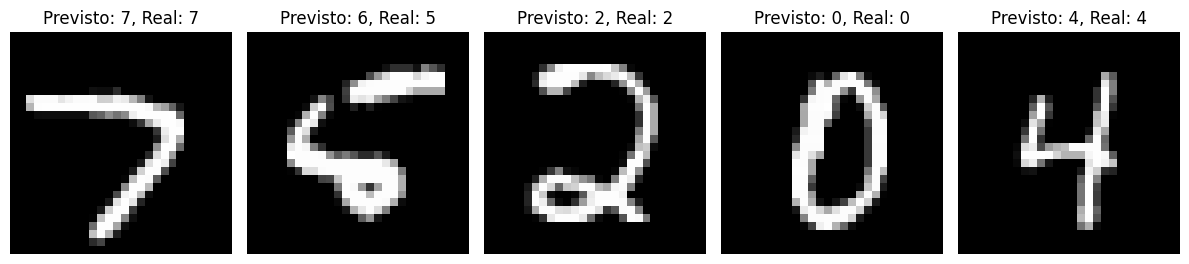

In [21]:
# Função para exibir várias imagens aleatórias com suas previsões
def show_random_images_with_predictions(dataset, model, num_images):
    # Iterando pelo DataLoader para acessar os dados
    for images, labels in dataset:
        break  # Isso garante que você tenha o primeiro lote de dados

    # Escolhendo índices aleatórios para visualizar várias imagens aleatórias
    indices = np.random.choice(len(images), num_images, replace=False)


    # Processamento das imagens e rótulos para obter previsões
    input_images = images[indices].view(-1, 28 * 28)  # Redimensiona as imagens para o formato adequado
    predictions = model(input_images)  # Obtém as previsões da rede

    # Plot das imagens com suas previsões
    plt.figure(figsize=(12, 6))
    for i, index in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        image = np.array(images[index].squeeze())
        label = labels[index]
        predicted_label = torch.argmax(predictions[i]).item()  # Obtém o rótulo previsto
        plt.imshow(image, cmap='gray')
        plt.title(f'Previsto: {predicted_label}, Real: {label}')
        plt.axis('off')  # Desabilita os eixos
    plt.tight_layout()
    plt.show()

# Chamando a função para exibir 5 imagens aleatórias com previsões da rede
show_random_images_with_predictions(teste_img, rede, 5)
